In [8]:
#NN Surrogate model class
import injector_surrogate_quads
from injector_surrogate_quads import *
import physics_gp
import os

sys.path.append('../configs')
#Sim reference point to optimize around
from ref_config import ref_point

#Pytorch 
import numpy as np
import torch
import gpytorch
import botorch 

# BO with 2nd Order Polynomial Prior
### BO Minimizes Emittance*Bmag with 9 Variables (SQ, CQ, SOL, matching quads)

In [9]:
# load injector model
Model = Surrogate_NN()

Model.load_saved_model(model_path = '../models/', \
                       model_name = 'model_OTR2_NA_rms_emit_elu_2021-07-27T19_54_57-07_00')
Model.load_scaling()
Model.take_log_out = False

In [10]:
# design Twiss parameters 
beamline_info = json.load(open('../configs/beamline_info.json'))
get_twiss0 = beamline_info['Twiss0']

# emit, beta, alpha
twiss0 = {'x': [get_twiss0[0], get_twiss0[2], get_twiss0[4]],
          'y': [get_twiss0[1], get_twiss0[3], get_twiss0[5]]}

beta0_x, alpha0_x = twiss0['x'][1], twiss0['x'][2]
beta0_y, alpha0_y = twiss0['y'][1], twiss0['y'][2]
# print(twiss0['x'])
# print(twiss0['y'])

## Objective Function

In [11]:
# convert to machine units
ref_point = Model.sim_to_machine(np.asarray(ref_point))

# input params: solenoid and quads to vary 
opt_var_names = ['SOL1:solenoid_field_scale','CQ01:b1_gradient', 'SQ01:b1_gradient',
                 "QA01:b1_gradient", "QA02:b1_gradient", 
                 "QE01:b1_gradient", "QE02:b1_gradient", "QE03:b1_gradient", "QE04:b1_gradient"]
bounds = torch.as_tensor([[0.46, 0.485], [-0.02, 0.02], [-0.02, 0.02],
                       [-4, -1], [1, 4],
                       [-7,-1], [-1, 7],[-1, 7], [-7, 1]])

# output params: emittance in transverse plane (x & y)
opt_out_names = ['norm_emit_x','norm_emit_y']

def evaluate(config): 
    """
    D is input space dimensionality
    :param config: input values of opt_var_names, torch.tensor, shape (1, D) 
    """
    #make input array of length model_in_list (inputs model takes)
    x_in = np.empty((1,len(Model.model_in_list)))

    #fill in reference point around which to optimize
    x_in[:,:] = np.asarray(ref_point[0])

    #set solenoid, CQ, SQ, matching quads to values from optimization step
    for i in range(config.size(dim=0)):
        x_in[:, Model.loc_in[opt_var_names[i]]] = config[i]

    #output predictions
    y_out = Model.pred_machine_units(x_in) 

    return -1*objective(y_out)[0]


def objective(y_out):
    # output is emittance * bmag 
    
    # geometric emittance in transverse plane
    out1 = y_out[:, Model.loc_out['norm_emit_x']] #grab norm_emit_x out of the model
    out2 = y_out[:, Model.loc_out['norm_emit_y']] #grab norm_emit_y out of the model
    emit = np.sqrt(out1 * out2)
  
    sigma_x = y_out[:, Model.loc_out['sigma_x']] #grab sigma_x out of the model 
    sigma_y = y_out[:, Model.loc_out['sigma_y']] #grab sigma_y out of the model 
    
    # real beta and alpha 
    # NEEDS TO BE FIXED - currently assuming real alpha to be the same as design alpha 
    alpha_x, alpha_y = alpha0_x, alpha0_y
    beta_x, beta_y = (sigma_x**2) / out1, (sigma_y**2) / out2
    
    # bmag 
    bmag_x = 0.5 * ((beta0_x / beta_x) + (beta_x / beta0_x)) + 0.5 * ((alpha_x * np.sqrt(beta0_x / beta_x) - alpha0_x * np.sqrt(beta_x / beta0_x))**2)
    bmag_y = 0.5 * ((beta0_y / beta_y) + (beta_y / beta0_y)) + 0.5 * ((alpha_y * np.sqrt(beta0_y / beta_y) - alpha0_y * np.sqrt(beta_y / beta0_y))**2)
    bmag = np.sqrt(bmag_x * bmag_y)
    #print(f'bmag: {bmag} emit: {emit}') 
    
    return (emit * bmag)/1e-6 # in um units 
    #return np.sqrt(out1*out2)/1e-6 # in um units

In [6]:
# mesh grid of 3^9 points to sample
n_samples_per_var = 3
n_var = 9

"""
create x and y if they are not saved in grid.pt, otherwise load x and y the next section 
"""
# create input and output data
if os.path.exists('./training_data/grid.pt') and os.stat('./training_data/grid.pt').st_size > 0: 
    training_dict = torch.load('grid.pt')
    x = training_dict['x']
    y = training_dict['y']
else: 
    var_points = torch.zeros((n_var, n_samples_per_var)) 
    # take n_samples_per_var points from each dimension i
    for i in range(n_var):
        var_points[i,:] = torch.linspace(bounds[i,0],bounds[i,1],n_samples_per_var)

    # generate grid of points to sample 
    grid = np.array(np.meshgrid(*var_points)).reshape(n_var,-1)
    x = torch.zeros((n_samples_per_var**n_var, n_var))
    for i in range(n_samples_per_var**n_var):
        x[i:] = torch.as_tensor(grid[:,i])
    y = torch.as_tensor([evaluate(ele) for ele in x])
    torch.save({'x': x, 'y': y}, 'grid.pt')

print(x)
print(x.shape)
print(y)

tensor([[ 0.4600, -0.0200, -0.0200,  ..., -1.0000, -1.0000, -7.0000],
        [ 0.4600, -0.0200, -0.0200,  ..., -1.0000, -1.0000, -3.0000],
        [ 0.4600, -0.0200, -0.0200,  ..., -1.0000, -1.0000,  1.0000],
        ...,
        [ 0.4850,  0.0200,  0.0200,  ...,  7.0000,  7.0000, -7.0000],
        [ 0.4850,  0.0200,  0.0200,  ...,  7.0000,  7.0000, -3.0000],
        [ 0.4850,  0.0200,  0.0200,  ...,  7.0000,  7.0000,  1.0000]])
torch.Size([19683, 9])
tensor([ -6.9780, -10.3164,  -5.1626,  ...,  -4.3536,  -6.9199,  -7.3886],
       dtype=torch.float64)


## Fit data with second order polynomial

In [7]:
# f(x) = x^T A x + B x + C
# x is a 9x1 column vector, A is a symmetric 9x9 matrix, B is a 1x9 vector, C is a scalar.
a_vals = torch.randn((int(n_var*(n_var+1)/2),1)).reshape(1,-1)
A = torch.zeros(n_var, n_var)
i, j = torch.triu_indices(n_var, n_var)
A[i, j] = a_vals
A.T[i, j] = a_vals
A = A.clone().detach().requires_grad_(True)
print(A)

B = torch.randn((1, n_var), requires_grad=True)
#print(B) 

C = torch.randn((1,1), requires_grad = True)
#print(C)

learning_rate = 1e-4
for i in range(2000):
    # if (i > 30 and i % 10 == 0 and learning_rate >= 1e-7):
    #     learning_rate /= 10
    y_pred = torch.cat([torch.matmul(ele, torch.matmul(A, ele.T)) + torch.matmul(B, ele.T) + C for ele in x]).reshape(1,-1)[0]

    loss = (y_pred - y).pow(2).mean() #
    if (i % 50 == 0):
        print(i, loss.item())
        print(y_pred)
    #print(loss.item())
    loss.backward()

    with torch.no_grad():
        A -= learning_rate * A.grad
        B -= learning_rate * B.grad
        C -= learning_rate * C.grad

        # Manually zero the gradients after updating weights
        A.grad = None
        B.grad = None
        C.grad = None

print(f'Result: y = x{A}X^T + {B} x + {C.item()}')
torch.save({'x': x, 'y': y, 'A': A, 'B': B, 'C': C, 'y_pred': y_pred}, 'grid.pt')

tensor([[ 0.1990,  0.1713, -0.0037,  1.8523, -1.4424,  0.1127, -1.2146, -1.2535,
         -0.7911],
        [ 0.1713,  0.2205, -0.0203, -1.3486, -1.4453,  1.2522, -2.2443, -2.0945,
          1.9241],
        [-0.0037, -0.0203,  1.2173, -0.2430,  0.4708, -0.9186, -0.2292, -0.7749,
          0.4640],
        [ 1.8523, -1.3486, -0.2430,  0.6051,  0.3601,  0.4847,  0.6617,  1.1334,
          0.2246],
        [-1.4424, -1.4453,  0.4708,  0.3601, -0.0258,  0.9295, -0.2002, -0.5427,
         -1.0870],
        [ 0.1127,  1.2522, -0.9186,  0.4847,  0.9295, -0.2737,  0.1053, -1.8286,
          1.9067],
        [-1.2146, -2.2443, -0.2292,  0.6617, -0.2002,  0.1053,  2.0457, -1.8193,
         -0.7664],
        [-1.2535, -2.0945, -0.7749,  1.1334, -0.5427, -1.8286, -1.8193, -0.1452,
         -0.3354],
        [-0.7911,  1.9241,  0.4640,  0.2246, -1.0870,  1.9067, -0.7664, -0.3354,
          0.4788]], requires_grad=True)
0 22810.84637985665
tensor([ 219.9231,   85.9642,  -32.6718,  ...,   49.5469,  

tensor([ 4.7797e-01, -1.4992e-03, -6.8730e-04, -2.0006e+00,  2.0006e+00,
        -2.0218e-01, -1.7939e-01,  2.8522e+00, -3.2184e+00],
       dtype=torch.float64)


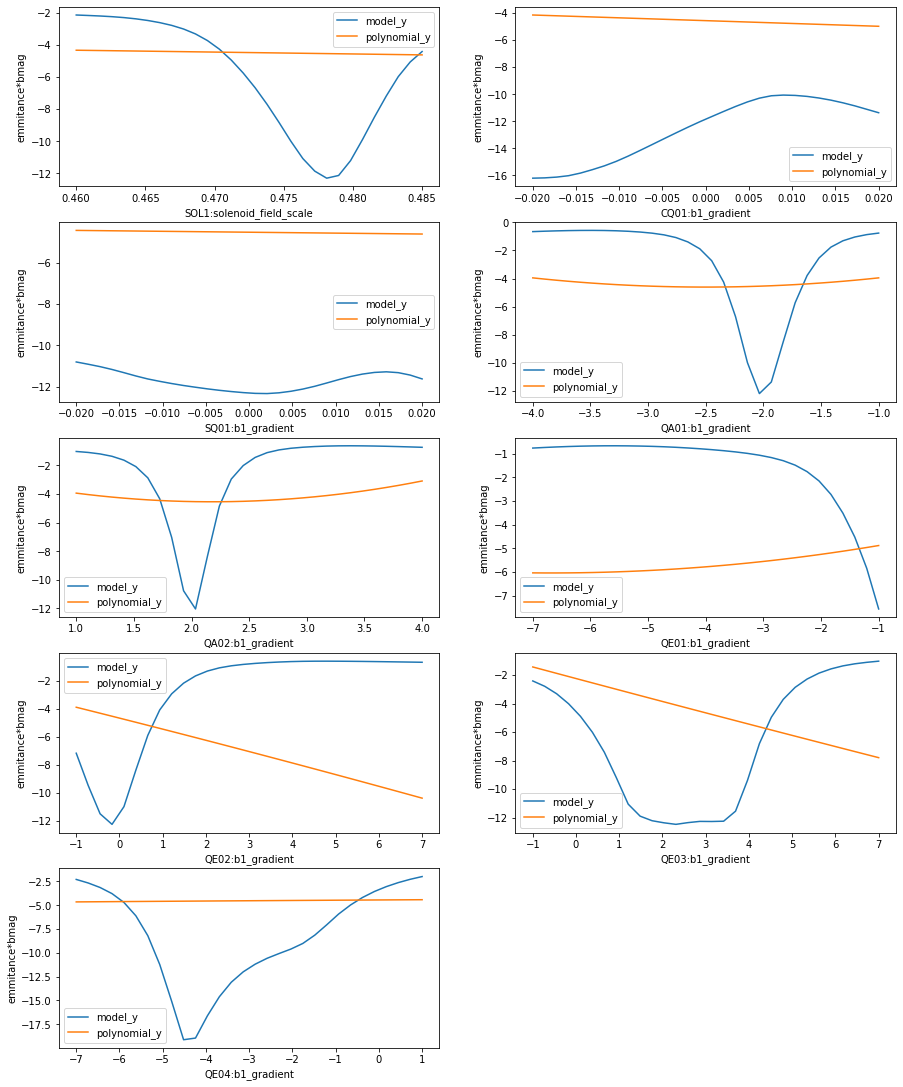

In [34]:
import matplotlib.pyplot as plt

# model  
training_dict = torch.load('grid.pt')
x = training_dict['x']
y = training_dict['y']
A = training_dict['A']
B = training_dict['B'] 
C = training_dict['C'] 
y_pred = training_dict['y_pred']

def polynomial_model(x):
    """
    :param x: input values, tensor, shape (num_samples, num_var) 
    returns y_pred as tensor, shape (1, num_samples) 
    """ 
    return torch.cat([torch.matmul(ele, torch.matmul(A, ele.T)) + torch.matmul(B, ele.T) + C for ele in x.float()]).reshape(1,-1)[0]

# scanning function 
# use ref point values for the parameters that are kept constant 
scan_ref_point = torch.cat([torch.as_tensor([ref_point[0][Model.loc_in[param_name]]]) for param_name in opt_var_names])
print(scan_ref_point) 

def scan(model_param, num_scans):
    """
    scans values across a single parameter of the model, keeping others constant
    :param model_param: name of the model param that is being scanned, string, size 1 
    :param num_scans: number of values scanned for parameter 
    returns model_test_y, polynomial_test_y of all scanned values  
    """ 
    param_index = opt_var_names.index(model_param)
    test_x = scan_ref_point.repeat(num_scans, 1) 
    test_x[:,param_index] = torch.linspace(bounds[param_index, 0], bounds[param_index, 1], num_scans)
    #print(test_x)
    
    model_test_y = torch.as_tensor([evaluate(ele) for ele in test_x])
    polynomial_test_y = polynomial_model(test_x) 
    return model_test_y, polynomial_test_y, test_x

plt.rcParams["figure.figsize"] = (15,35)
for i in range(len(opt_var_names)):
    model_param = opt_var_names[i] 
    model_test_y, polynomial_test_y, test_x = scan(model_param, 30) 
    plt.subplot(9, 2, i+1)
    plt.xlabel(model_param)
    plt.ylabel('emmitance*bmag')
    plt.plot(test_x[:,opt_var_names.index(model_param)], model_test_y, label = "model_y")
    plt.plot(test_x[:,opt_var_names.index(model_param)], polynomial_test_y.detach(), label = "polynomial_y")
    plt.legend()
    
plt.show()